## Case Study: Hypothesis Testing and Confidence Intervals

### Motivation: Retention in Online Courses

In this video, we'll bring together everything we've learned and try to answer some interesting questions about online learning. Along the way, we're also going to learn about hypothesis testing and confidence intervals, and see how these concepts can help us draw conclusions in real-life situations.

![MADS degree](assets/mads.png)

As a student working towards an online degree, you might be well acquainted with both the benefits and challenges of taking classes via the internet. Perhaps you took part in an Massively Open Online Course (or MOOC) on Coursera prior to joining the MADS program.

If so, you may have noticed that there's often a large drop-off in students initially, which then continues, albeit at a much slower rate throughout the MOOC. So, one of the questions we've tried to address through research is how we can run adaptive interventions in scaled digital learning environments to prompt users into returning to a course.  

### Description of the Study

To do so, we ran a series of randomized trials in various sequences. That is, an email was sent out to a sample of Indian and US-based learners for the first three weeks in UM's Applied Data Science with Python MOOC on Coursera. 

![sample email](assets/email.png)

There's quite a few components going on here, so to keep things simple, let's just focus on a few key questions. Which type of email will be most effective at bringing learners back to the course? Is this the same for different regions? Also, among the emails with some sort of problem given to learners, is a culturally relevant one more effective, or perhaps a more global non-culture specific problem?

To answer these questions, we would somehow have to look for differences between these various conditions, and so we divided our participants into four groups: those who received a *cultural problem email* (A and B), a *global problem email* (D and F), an email with *no problem* (just C and E), or *no email* at all.

### Understanding the Dataset: Preprocessing and Exploration

Now let's take a look at the data from running those four treatments and see if there are any differences between groups. First, we'll explore the dataset and see how it's formatted.

In [1]:
import pandas as pd

df = pd.read_csv('assets/full_data.csv')
df.head(10)

#Reading in the csv file, note that each participant is represented by a row in this dataframe. 
#Note that there's information on which week of the course we're in, what sort of treatment was 
#given, a user's total clicks, and what country they're from. 

,Unnamed: 0,week,treatment_id,experiment,click_sum,week_fac,prob_based,exp_factor,click_ind,country
0,1,1,2,1,78,week 1,no_prob,1,1,US
1,6,1,7,1,68,week 1,rel_prob_email,1,1,US
2,10,1,4,1,136,week 1,prob_email,1,1,US
3,13,1,7,1,0,week 1,rel_prob_email,1,0,US
4,18,1,7,1,0,week 1,rel_prob_email,1,0,US
5,20,1,5,1,160,week 1,prob_email,1,1,US
6,21,1,3,1,136,week 1,no_prob,1,1,US
7,25,1,1,1,52,week 1,no_email,1,1,US
8,30,1,7,1,0,week 1,rel_prob_email,1,0,US
9,43,1,3,1,0,week 1,no_prob,1,0,US


Now that we have some idea of how the data are structured, let's do some further visual exploration to try and understand the effects of changing the treatment. Let's just stick with US learners for now.

(array([1.5447e+04, 3.8600e+02, 5.3000e+01, 1.8000e+01, 5.0000e+00,
        1.0000e+00, 3.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([   0. ,  270.4,  540.8,  811.2, 1081.6, 1352. , 1622.4, 1892.8,
        2163.2, 2433.6, 2704. ]),
 <BarContainer object of 10 artists>)

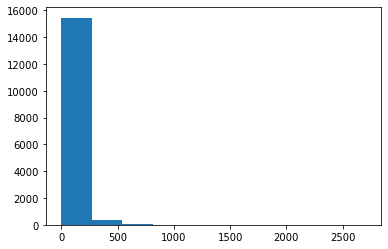

In [2]:
#One thing that might be interesting to plot is the distribution of clicks, 
#which we might want to use as a sort of proxy for online engagement.

%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(df['click_sum'])

(array([1.219e+04, 7.000e+00, 2.360e+02, 3.470e+02, 6.410e+02, 7.900e+02,
        9.450e+02, 6.600e+02, 8.800e+01, 1.300e+01]),
 array([-0.69314718,  0.16643477,  1.02601672,  1.88559867,  2.74518062,
         3.60476258,  4.46434453,  5.32392648,  6.18350843,  7.04309038,
         7.90267233]),
 <BarContainer object of 10 artists>)

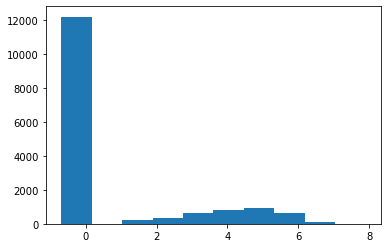

In [3]:
#Notice that's it's heavily skewed! Fortunately, we've already discussed how to address this, namely, 
#by taking a transformation. So, let's try using a log transform before re-plotting.

import numpy as np

#It's important to mention that we want to avoid taking the log of 0. So, to work around this, we'll
#just add a small fixed constant before applying the transformation.

df['log_click_sum'] = np.log(df['click_sum'] + 0.5)
plt.hist(df['log_click_sum'])

#Things are looking much better, and there's a somewhat normal-looking distribution of values, 
#despite the large number of zero values that remain.

In [4]:
#Now let's compute some summary statistics: the mean, standard deviation, and sample sizes
#if we were to group everything by treatment and week of study.

#We can do this by using pandas groupby function.
#The documentation can be found here: 
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html

subset = df[['week', 'prob_based', 'log_click_sum', 'country']]
us_subset = subset[subset['country'] == 'US']

us_subset.groupby(['week', 'prob_based']).std().reset_index()

,week,prob_based,log_click_sum
0,1,no_email,2.472656
1,1,no_prob,2.497057
2,1,prob_email,2.390853
3,1,rel_prob_email,2.435976
4,2,no_email,2.094004
5,2,no_prob,2.034019
6,2,prob_email,2.085403
7,2,rel_prob_email,2.062172
8,3,no_email,1.916631
9,3,no_prob,1.948697


In [5]:
#Then, we'll create a new dataframe and attach each computation as a separate column.
us_df = us_subset.groupby(['week', 'prob_based']).size().to_frame(name = 'count').reset_index()
us_df['log_click_mean'] = us_subset.groupby(['week', 'prob_based']).mean().reset_index()['log_click_sum']
us_df['log_click_sd'] = us_subset.groupby(['week', 'prob_based']).std().reset_index()['log_click_sum']

us_df

,week,prob_based,count,log_click_mean,log_click_sd
0,1,no_email,567,0.956651,2.472656
1,1,no_prob,1175,0.986519,2.497057
2,1,prob_email,1082,0.808147,2.390853
3,1,rel_prob_email,1070,0.892844,2.435976
4,2,no_email,395,0.386900,2.094004
5,2,no_prob,814,0.311770,2.034019
6,2,prob_email,784,0.402776,2.085403
7,2,rel_prob_email,876,0.379896,2.062172
8,3,no_email,383,0.199064,1.916631
9,3,no_prob,707,0.148435,1.948697


In [6]:
#Let's repeat the same process for learners in India.

in_subset = subset[subset['country'] == 'IN']

in_df = in_subset.groupby(['week', 'prob_based']).size().to_frame(name = 'count').reset_index()
in_df['log_click_mean'] = in_subset.groupby(['week', 'prob_based']).mean().reset_index()['log_click_sum']
in_df['log_click_sd'] = in_subset.groupby(['week', 'prob_based']).std().reset_index()['log_click_sum']

in_df

,week,prob_based,count,log_click_mean,log_click_sd
0,1,no_email,371,0.616665,2.247813
1,1,no_prob,760,0.657835,2.268515
2,1,prob_email,825,0.607911,2.253470
3,1,rel_prob_email,785,0.716573,2.338417
4,2,no_email,313,0.026271,1.755674
5,2,no_prob,599,0.276774,2.035624
6,2,prob_email,611,0.239317,1.990815
7,2,rel_prob_email,592,0.198637,1.924204
8,3,no_email,238,-0.141014,1.540185
9,3,no_prob,485,0.053474,1.752842


### Introduction to Hypothesis Testing 

Now that we've organized our data and seperated it into two categories: US and Indian learners, let's go ahead and compare the mean log clicks to see if there are any interesting visual features for each of the three weeks. 

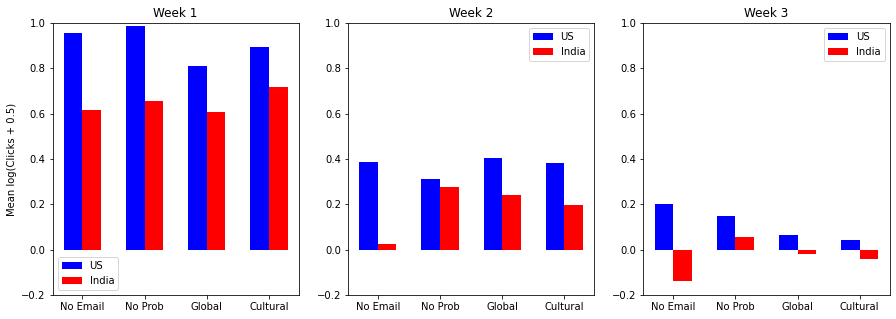

In [7]:
width = 0.3
idx = np.arange(4)

#We haven't covered subplots yet, so don't worry if some of the code below is unfamiliar.
#This is going to be discussed next week, but for now, we're going to use it so that we can
#present three plots, one for each week, side-by-side.
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131)

#First, we'll plot the log click means for week 1 across three of the four conditions 
#(no email, global problem, and cultural problem), and compare US versus India learners as well.
x = ['None', 'Global', 'Cultural']
us_wk1 = [row for row in us_df[us_df.week == 1]['log_click_mean']]
in_wk1 = [row for row in in_df[in_df.week == 1]['log_click_mean']]

rects1 = ax.bar(idx, us_wk1, width=width, color = 'b')
rects2 = ax.bar(idx+width, in_wk1, width=width, color = 'r')
ax.set_ylabel('Mean log(Clicks + 0.5)')

#Now let's repeat the same thing for the remaining two weeks.
ax2 = fig.add_subplot(132)
us_wk2 = [row for row in us_df[us_df.week == 2]['log_click_mean']]
in_wk2 = [row for row in in_df[in_df.week == 2]['log_click_mean']]
rects1 = ax2.bar(idx, us_wk2, width=width, color = 'b')
rects2 = ax2.bar(idx+width, in_wk2, width=width, color = 'r')

ax3 = fig.add_subplot(133)
us_wk3 = [row for row in us_df[us_df.week == 3]['log_click_mean']]
in_wk3 = [row for row in in_df[in_df.week == 3]['log_click_mean']]
rects1 = ax3.bar(idx, us_wk3, width=width, color = 'b')
rects2 = ax3.bar(idx+width, in_wk3, width=width, color = 'r')

#Finally, let's label everything appropriately, add some legends, and apply proper spacing on the axes.
for i, axis in enumerate([ax, ax2, ax3], start=1):
    axis.set_ylim((-0.2, 1))
    axis.set_title('Week %i' % i)
    axis.set_xticks(idx+0.5*width)
    axis.set_xticklabels( ('No Email', 'No Prob', 'Global', 'Cultural') )
    axis.legend( (rects1[0], rects2[0]), ('US', 'India') )


There's quite a bit going on here, so I'll point your attention to a few things in particular. We've made the scales on the y-axis the same, so that it's easier to compare between weeks. In general, activity seems to steadily decrease each week. 

Also, for Indian learners, sending an email seems to increase the likelihood that they'll return to the course, though it's not super clear if including a problem helps. For US learners, sending email doesn't seem to have much effect, and later on, even appears to deter people from returning!

However, is this phenomenon actually true? Or did we just happen to choose a "lucky" sample? Fortunately, statistics will provide us the tools to be a tad more rigorous and help us better quantify the certainty of our inferences.

For instance, one question I may have is whether or not there is truly that big of a discrepancy between US and Indian learners. In other words, are their means *statistically significantly different*.

So, our **null hypothesis** would be that their means are not significantly different, or that,
$$ H_0: \mu_{US} = \mu_{IN} $$

and the **alternative hypothesis** is that the means are different:
$$H_a: \mu_{US} \neq \mu_{IN} $$

To find out, we can conduct a hypothesis test. The diagram below gives you a taste of a small subset of the many statistical tests out there, and some of the considerations when deciding which one to use.

![statistical tests](assets/tests.jpg)

In this case, we're working with two samples, which we'll assume to be independent. Since we have such large samples sizes, let's go with a z-test. You might recall from a previous video that we talked about computing a z-statistic for a sampling distribution. We're going to make a slight modification for a two-sample test:

$$z = \frac{(\bar{x_1} - \bar{x_2}) - (\mu_1 - \mu_2)}{ \sqrt{\frac{\sigma_1^2}{n_1} + \frac{\sigma_2^2}{n_2}}}$$

We will consider this to be significant at $\alpha = 0.05$ level only if there's less than a 5% chance we reject the null hypothesis even when it's true (a false positive). Keep in mind that you get to select this threshold, although typical values are 0.05, 0.01, 0.001, and so forth. 

In this case we're conducting a two-tailed test, since we don't care about the direction of the difference, just whether or not the means *are* different. This is why we divide up the 0.05 area into two 0.025 regions at both ends. From there, we just need to calculate the **critical value** $z_{\alpha/2}$, or the z-score needed to achieve this benchmark, and compare it with our sample's z-score.
![z-test diagram](assets/index.png)

In [8]:
#One way of doing this would be to, given a significance level, lookup the critical value in a table somewhere 
#either in a textbook or online. Luckily for us though, we'll just use technology to find the correct values. 
import scipy.stats as stats

us_df_test = us_df[(us_df.week == 1) & (us_df.prob_based == 'no_prob')]
in_df_test = in_df[(in_df.week == 1) & (in_df.prob_based == 'no_prob')]

#Let's just look at week 1 for the "no email" condition.
x = us_df_test['log_click_mean'] - in_df_test['log_click_mean']
mu = 0
se = np.sqrt((us_df_test['log_click_sd']**2/us_df_test['count']) + \
               (in_df_test['log_click_sd']**2/in_df_test['count']))

z = (x - mu)/se
print(z)

#Now let's compare this to the critical value.
print(stats.norm.ppf(.975))
print(stats.norm.ppf(.025))

1    2.990771
dtype: float64
1.959963984540054
-1.9599639845400545


Since $z > z_{\alpha/2}$, we reject the null hypothesis $H_0$. And so, as our intuition may expect, the means between the two countries is significantly different.

### Confidence Intervals

While it's great that we now have the tools of hypothesis testing and we can compute z-scores for some other pairing of your choice, it would be nice to get some sense of the error visually. 

One common way of doing this is by showing confidence intervals, which are constructed as follows:

$$ \bar{X} \pm z_{\alpha/2}\frac{\sigma}{\sqrt{N}} $$

This means that if the population is sampled numerous times, then the resulting interval would capture the true mean 95% of the time (for $\alpha = 0.05$; the percentage will, of course, be different if you select a different threshold).

In [9]:
#Let's calculate the 95% CIs for each of our experimental conditions.
us_df['upper_bound'] = us_df['log_click_mean'] + 1.96 * us_df['log_click_sd'] / np.sqrt(us_df['count'])
us_df['lower_bound'] = us_df['log_click_mean'] - 1.96 * us_df['log_click_sd'] / np.sqrt(us_df['count'])
us_df['width'] = (us_df['upper_bound'] - us_df['lower_bound']) / 2

in_df['upper_bound'] = in_df['log_click_mean'] + 1.96 * in_df['log_click_sd'] / np.sqrt(in_df['count'])
in_df['lower_bound'] = in_df['log_click_mean'] - 1.96 * in_df['log_click_sd'] / np.sqrt(in_df['count'])
in_df['width'] = (in_df['upper_bound'] - in_df['lower_bound']) / 2

us_df

,week,prob_based,count,log_click_mean,log_click_sd,upper_bound,lower_bound,width
0,1,no_email,567,0.956651,2.472656,1.160181,0.753121,0.203530
1,1,no_prob,1175,0.986519,2.497057,1.129299,0.843740,0.142779
2,1,prob_email,1082,0.808147,2.390853,0.950608,0.665686,0.142461
3,1,rel_prob_email,1070,0.892844,2.435976,1.038806,0.746883,0.145961
4,2,no_email,395,0.386900,2.094004,0.593408,0.180393,0.206507
5,2,no_prob,814,0.311770,2.034019,0.451503,0.172038,0.139733
6,2,prob_email,784,0.402776,2.085403,0.548754,0.256797,0.145978
7,2,rel_prob_email,876,0.379896,2.062172,0.516458,0.243335,0.136562
8,3,no_email,383,0.199064,1.916631,0.391017,0.007111,0.191953
9,3,no_prob,707,0.148435,1.948697,0.292080,0.004790,0.143645


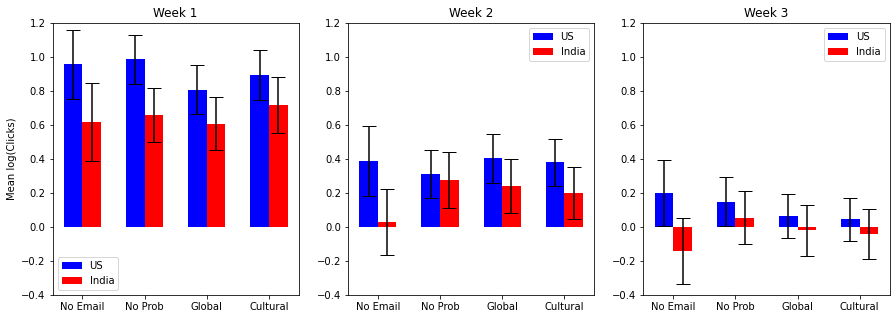

In [10]:
#Finally, let's include these as error bars for our plot from before.
width = 0.3
idx = np.arange(4)

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131)

x = ['None', 'Global', 'Cultural']
us_wk1 = [row for row in us_df[us_df.week == 1]['log_click_mean']]
in_wk1 = [row for row in in_df[in_df.week == 1]['log_click_mean']]
us_ci1 = [row for row in us_df[us_df.week == 1]['width']]
in_ci1 = [row for row in in_df[in_df.week == 1]['width']]

rects1 = ax.bar(idx, us_wk1, width=width, yerr=us_ci1, capsize=7, color = 'b')
rects2 = ax.bar(idx+width, in_wk1, width=width, yerr=in_ci1, capsize=7, color = 'r')
ax.set_ylabel('Mean log(Clicks)')

ax2 = fig.add_subplot(132)
us_wk2 = [row for row in us_df[us_df.week == 2]['log_click_mean']]
in_wk2 = [row for row in in_df[in_df.week == 2]['log_click_mean']]
us_ci2 = [row for row in us_df[us_df.week == 2]['width']]
in_ci2 = [row for row in in_df[in_df.week == 2]['width']]

rects1 = ax2.bar(idx, us_wk2, width=width, yerr=us_ci2, capsize=7, color = 'b')
rects2 = ax2.bar(idx+width, in_wk2, width=width, yerr=in_ci2, capsize=7, color = 'r')

ax3 = fig.add_subplot(133)
us_wk3 = [row for row in us_df[us_df.week == 3]['log_click_mean']]
in_wk3 = [row for row in in_df[in_df.week == 3]['log_click_mean']]
us_ci3 = [row for row in us_df[us_df.week == 3]['width']]
in_ci3 = [row for row in in_df[in_df.week == 3]['width']]

rects1 = ax3.bar(idx, us_wk3, width=width, yerr=us_ci3, capsize=7, color = 'b')
rects2 = ax3.bar(idx+width, in_wk3, width=width, yerr=in_ci3, capsize=7, color = 'r')

for i, axis in enumerate([ax, ax2, ax3], start=1):
    axis.set_ylim((-0.4, 1.2))
    axis.set_title('Week %i' % i)
    axis.set_xticks(idx+0.5*width)
    axis.set_xticklabels( ('No Email', 'No Prob', 'Global', 'Cultural') )
    axis.legend( (rects1[0], rects2[0]), ('US', 'India') )
    
#Note that those bars with less overlap are more likely to be significantly different from each other,
#and vice versa. (add more description here)

### Conclusion

As we've seen, using problems in email interventions might be an effective strategy for some regions, where as you may be better off leaving people alone in another. Now this analysis doesn't really explain why, but I'll leave that to your interpretation. Furthermore, the actual details are a bit more complicated such as the use of sequential randomized trials (or SRTs) rather than A/B testing. There are also numerous factors that we control for such as [blah blah ask Tim, talk about discrepancies with details in paper], and as such, we show the log odds ratios of logistic regression parameters trained on the dataset, rather than just using raw clicks. You'll learn more about these some of these topics in the supervised machine learning course. If you're interested in finding more about the research in general, here's a link to the [full paper](https://arxiv.org/pdf/1810.11185.pdf).

![figure from paper](assets/fig_4.png)

All in all, you've learned a great deal this unit, and congrats for making it to the end of week one! We've talked about the basics of charting and plotting using matplotlib, and reviewed important statistical concepts such as hypothesis testing, transformations, and centrality measures. 

In the homework assignment for this week, you'll get the opportunity to synthesize everything we've learned and analyze a case study on your own. So, have fun with the Jupyter notebook, and we'll see you in week two!